In [ ]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Mon Dec 04 21:02 UTC 2025
# Version:        1.0.1
# =============================================================================
"""The Module has been build for training the symbols dataset with the 
following datasets consisting of images + ground truth. Images have the base 
dimenstions of 640px x 480px in datasets 1-8 and then another 700 images with 
resolution 1920px x 1080px have been added to the datasets9+.
The files in the dataset <symbols> should be ordered in the following
manner starting with dataset10+:
- symbols      
  - # dataset e.g. datset10 the corresponding classes are stored in folders 0-3:
    #     classA/     = cross       351
    #     classB/     = circle      348
    #     classC/     = triangle    350
    #     classD/     = rectangle   351
"""

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Enable Nvidia GPUs by un-commenting this line 
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/"

SEED = 42

2025-12-04 20:38:36.523756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# =============================================================================
# Declare variables
# =============================================================================
# Change the following paths to your dataset path
home_dir = os.path.expanduser("~/git")
dataset_for_training = home_dir + "/ml_project/datasets/symbols/dataset10"

print("Dataset:", dataset_for_training)

Dataset: /home/kai/git/ml_project/datasets/symbols/dataset10


In [3]:
# =============================================================================
# Dataset related
# =============================================================================
NUM_CLASSES = 4
IMG_SIZE_X = 160
IMG_SIZE_Y = 160
IMG_SIZE = (IMG_SIZE_X, IMG_SIZE_Y)

INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 3) # color
#INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 1) # grayscale

# =============================================================================
# Hyperparameters
# =============================================================================
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 1e-4

# Set up an exponential decay learning rate schedule
LR_SCHEDULER = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,    # start with 0.001
    decay_steps=500,                        # how often to apply the decay
    decay_rate=0.96,                        # decay rate
    staircase=True                          # whether to apply the decay in steps
)
OPTIMIZER_BASE = keras.optimizers.Adam(learning_rate=LR_SCHEDULER)

LR_SCHEDULER_FINE = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE/10, # start with 0.001
    decay_steps=500,                        # how often to apply the decay
    decay_rate=0.96,                        # decay rate
    staircase=True                          # whether to apply the decay in steps
)
OPTIMIZER_FINE = keras.optimizers.RMSprop(learning_rate=LR_SCHEDULER_FINE)

I0000 00:00:1764877119.792725   24642 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4617 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    labels="inferred",
    label_mode="categorical",           # 4 Klassen → 1-hot
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.
Found 1400 files belonging to 4 classes.
Using 280 files for validation.


In [5]:
class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print("Klassen:", class_names, "\n")

Klassen: ['0', '1', '2', '3'] 



2025-12-04 20:38:41.472470: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


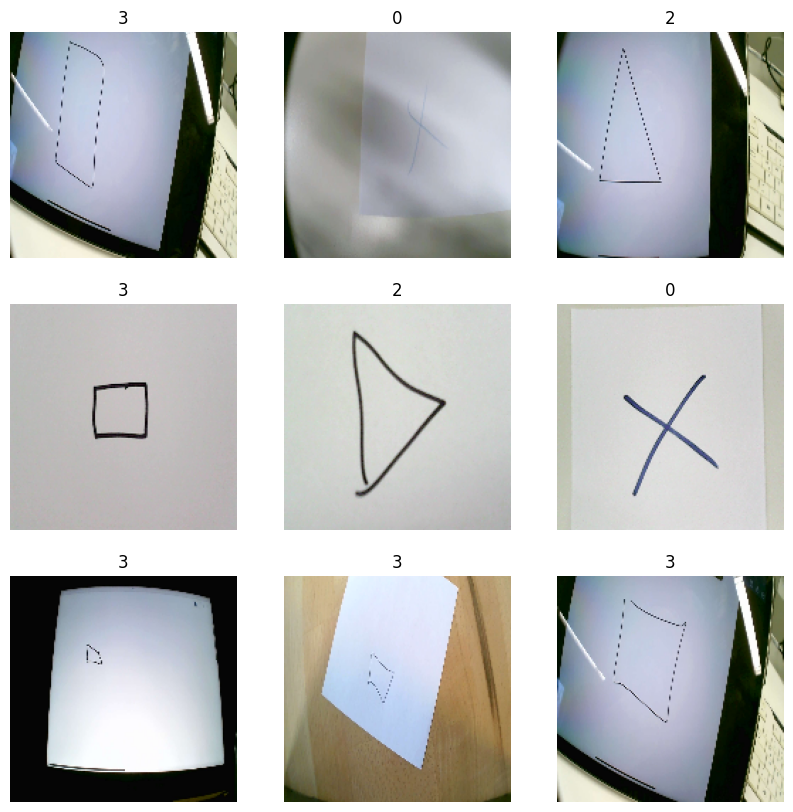

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index])
        plt.axis("off")


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(val_batches // 5)
#validation_dataset = validation_dataset.skip(val_batches // 5)
test_dataset = validation_dataset.take(val_batches // 4)
validation_dataset = validation_dataset.skip(val_batches // 4)

In [8]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of training batches: 35
Number of validation batches: 7


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of testing batches: 2


In [10]:
# =============================================================================
# Data Augmentation
# =============================================================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.2),   
])

# =============================================================================
# Full Data Augmentation Pipeline
# =============================================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),             # flip left/right
    layers.RandomRotation(0.1),                  # rotate ±10%
    layers.RandomZoom(0.1),                      # zoom in/out
    layers.RandomTranslation(0.1, 0.1),          # shift X/Y
    layers.RandomBrightness(factor=0.1),         # color jitter (TF 2.15+)
    layers.RandomContrast(0.1),                  # adjust contrast
    layers.RandomGaussianBlur(
        kernel_size=3,     # size of blur kernel (3, 5, etc.)
        sigma=(0.1, 2.0)   # range of possible blur intensity
    )  
])

2025-12-04 20:38:45.656965: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


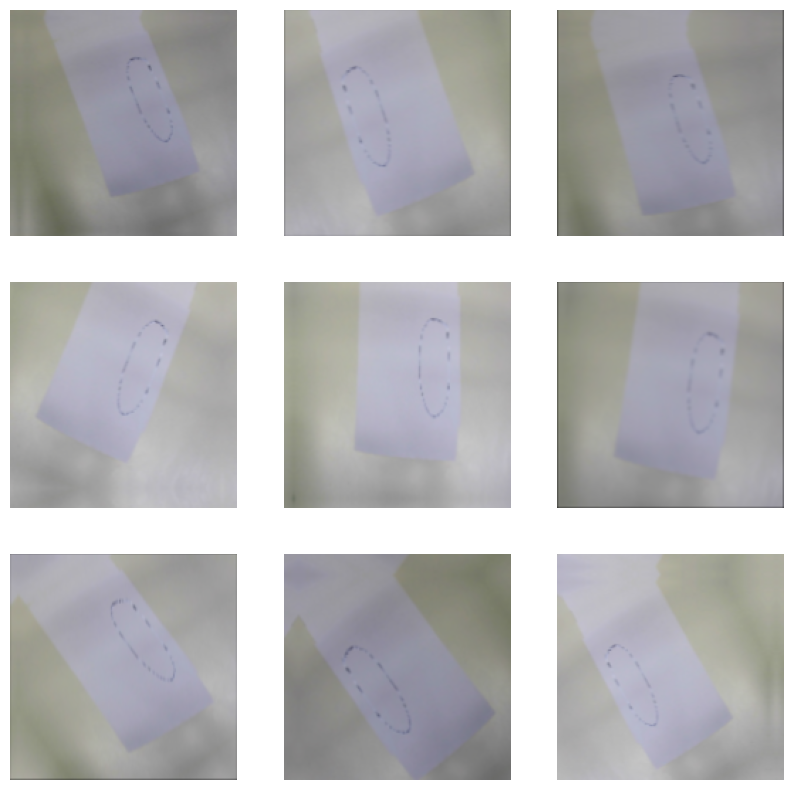

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [12]:
# AUTOTUNE
# =============================================================================
# TensorBoard Logging
# =============================================================================
log_dir = "logs/fit"
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Starten in Shell: tensorboard --logdir logs/fit

In [13]:
# =============================================================================
# MobileNetV2 (Transfer Learning)
# =============================================================================
base_model = tf.keras.applications.MobileNetV2(
#base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

# Let's take a look at the base model architecture
#base_model.summary()

In [14]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers
inputs = keras.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # best
#x = tf.keras.applications.mobilenet_v3.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(LR_SCHEDULER),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',       # metric to monitor
    save_best_only=True,      # only save when metric improves
    mode='min',               # 'min' for loss, 'max' for accuracy
    verbose=1,                # Print a line when the model is saved
)

In [17]:
# =============================================================================
# Training (Feature Extraction)
# =============================================================================
initial_epochs = 100 # best: 50

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs,
    shuffle=True,
    callbacks=[checkpoint,
               tensorboard_callback],
)

# Starten in Shell: tensorboard --logdir logs/fit

Epoch 1/100


2025-12-04 20:38:52.099695: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91501


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3066 - loss: 1.7082
Epoch 1: val_loss improved from None to 1.36396, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.3384 - loss: 1.5885 - val_accuracy: 0.4167 - val_loss: 1.3640
Epoch 2/100
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3989 - loss: 1.4050
Epoch 2: val_loss improved from 1.36396 to 1.21737, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.4062 - loss: 1.3569 - val_accuracy: 0.4815 - val_loss: 1.2174
Epoch 3/100
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4613 - loss: 1.2354
Epoch 3: val_loss improved from 1.21737 to 1.07444, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.4884 - loss: 1.1884 - val_accuracy: 0.5509 - val_loss: 1.0744
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5323 - loss: 1.1287
Epoch 4: val_loss improved from 1.07444 to 0.97458, saving model

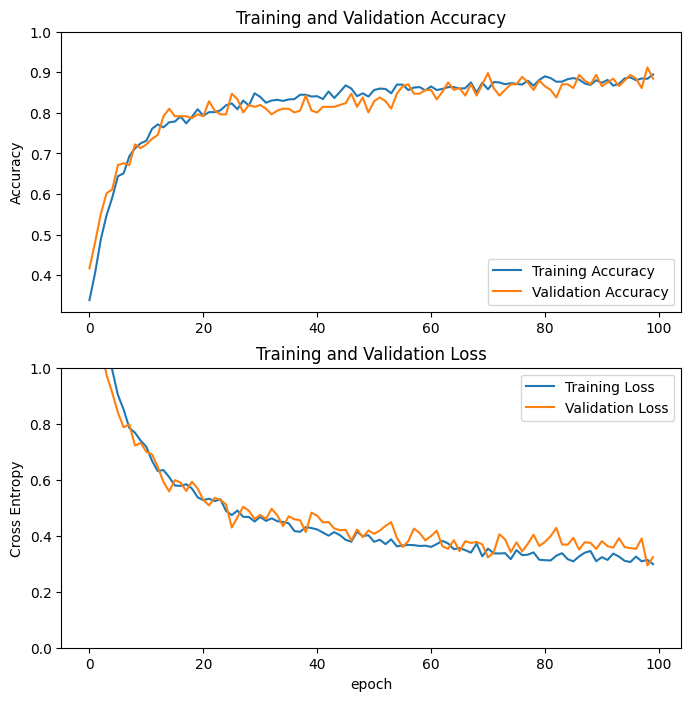

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
# =============================================================================
# Fine Tuning
# =============================================================================
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_from = 100

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.RMSprop(LR_SCHEDULER_FINE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 100 # best: 100
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         validation_data=validation_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         shuffle=True,
                         callbacks=[checkpoint,
                                    tensorboard_callback],
)

Number of layers in the base model:  154
Epoch 101/200
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6954 - loss: 0.8575
Epoch 101: val_loss did not improve from 0.29414
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.7223 - loss: 0.7633 - val_accuracy: 0.8519 - val_loss: 0.3719
Epoch 102/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7724 - loss: 0.6286
Epoch 102: val_loss did not improve from 0.29414
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7768 - loss: 0.5914 - val_accuracy: 0.8194 - val_loss: 0.4137
Epoch 103/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7844 - loss: 0.5386
Epoch 103: val_loss did not improve from 0.29414
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.8107 - loss: 0.4967 - val_accuracy: 0.8380 - val_loss: 0.3966
Epoch 104/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8245 - loss: 0.4431
Epoch 104: val_loss did not improve from 0.29414
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.8277

In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

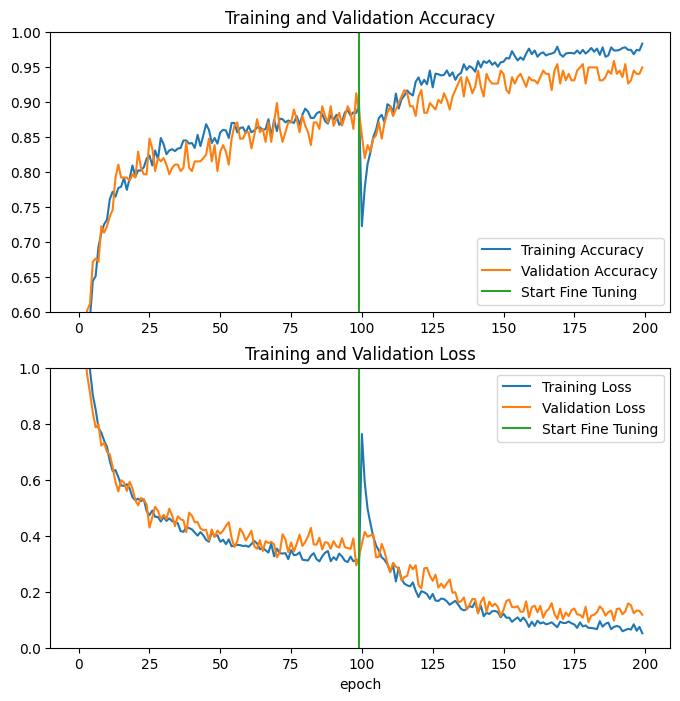

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
# =============================================================================
# Test Accuracy (Validation = Test)
# =============================================================================
loss, acc = model.evaluate(validation_dataset)
#TODO loss, accuracy = model.evaluate(test_dataset)

print("Test Accuracy:", acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9398 - loss: 0.1350
Test Accuracy: 0.9398148059844971


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Klassen: ['0', '1', '2', '3']


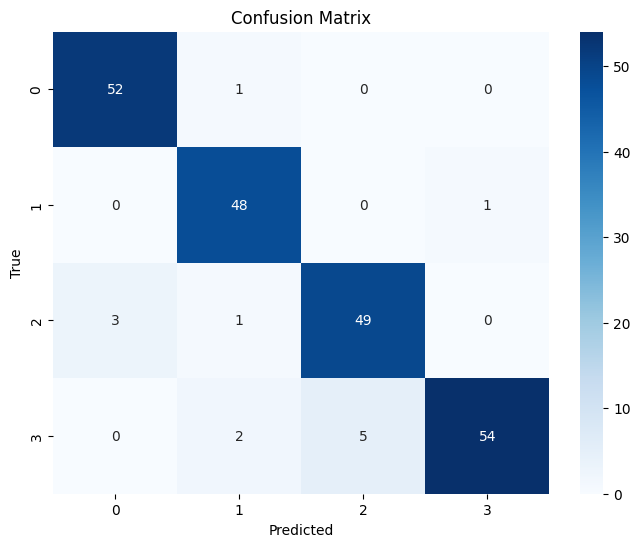


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        53
           1       0.92      0.98      0.95        49
           2       0.91      0.92      0.92        53
           3       0.98      0.89      0.93        61

    accuracy                           0.94       216
   macro avg       0.94      0.94      0.94       216
weighted avg       0.94      0.94      0.94       216



In [ ]:
# =============================================================================
# Konfusionsmatrix + Klassifizierungsreport
# =============================================================================
# Daten aus Validation/Test holen
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Klassenliste
print("Klassen:", class_names)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [24]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9062 - loss: 0.2146
Test accuracy : 0.90625


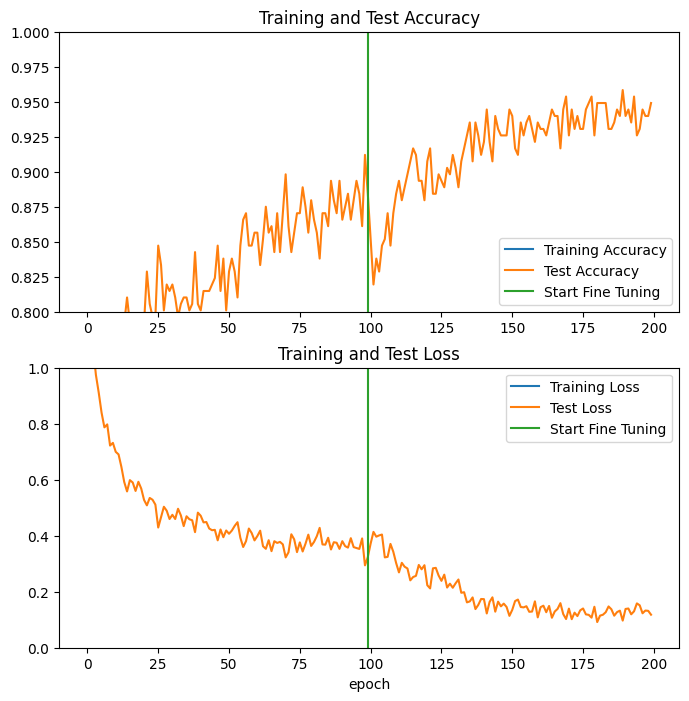

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Test Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.xlabel('epoch')
plt.show()

Last conv layer: Conv_1
tf.Tensor([[9.9999440e-01 3.1804611e-06 9.5618248e-07 1.4204627e-06]], shape=(1, 4), dtype=float32)


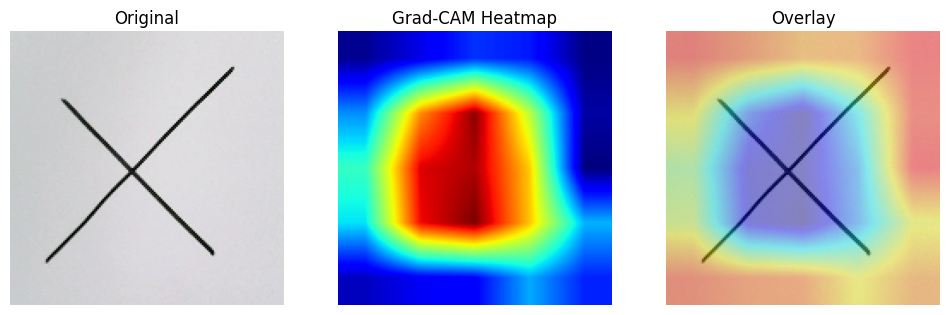

Predicted class: 0


In [26]:
# =============================================================================
# Grad-CAM Visualisierung
# =============================================================================

# ============================================================
# 1. Extract MobileNetV2 backbone
# ============================================================
backbone = model.get_layer("mobilenetv2_1.00_160")

# Find last conv layer inside MobileNetV2
last_conv = None
for layer in reversed(backbone.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer
        break

print("Last conv layer:", last_conv.name)


# ============================================================
# 2. Create a Grad-CAM model for MobileNetV2 only
# ============================================================
grad_model = tf.keras.models.Model(
    inputs=backbone.input,            # internal input of MobileNetV2
    outputs=[last_conv.output,        # feature map
             backbone.output]         # MobileNetV2 embeddings
)


# ============================================================
# 3. Extract and preprocess image manually (bypass Sequential)
# ============================================================
example_img, _ = next(iter(validation_dataset))
example_img = example_img[0].numpy() # shape: (H,W,3)

# Your model expects raw 0–255
if example_img.max() <= 1.0:
    example_img = example_img * 255.

# Apply SAME preprocessing as your Sequential layer
# Apply Rescaling(1./127.5, offset=-1) manually
img_pp = (example_img / 127.5) - 1

# final MobileNetV2 input
input_backbone = np.expand_dims(img_pp, 0)


# ============================================================
# 4. Run Grad-CAM on the backbone
# ============================================================
with tf.GradientTape() as tape:
    conv_outputs, features = grad_model(input_backbone)
    conv_outputs = conv_outputs[0]

# use full model for final class prediction
full_pred = model(np.expand_dims(example_img, 0))
pred_index = tf.argmax(full_pred[0]).numpy()
print(full_pred)

# MobileNetV2 embeddings → Dense layer → final class  
dense_weights = model.layers[-1].get_weights()[0]     # (1280, num_classes)
weights_for_class = dense_weights[:, pred_index]       # shape (1280,)

# Compute Grad-CAM manually from MobileNetV2 embeddings
grads = weights_for_class
heatmap = tf.reduce_sum(tf.multiply(conv_outputs, grads), axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max() + 1e-8


# ============================================================
# 5. Visualization
# ============================================================
img_uint8 = example_img.astype("uint8")

heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)


plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_uint8)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap='jet')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()

print("Predicted class:", class_names[pred_index])


In [27]:
# =============================================================================
# Modell speichern
# =============================================================================
keras.saving.save_model(model, "model.keras")

print("Modelle gespeichert: model.keras")

# =============================================================================
# Modell laden
# =============================================================================
loaded_model = keras.models.load_model("model.keras")

print("Modelle erfolgreich geladen!")

Modelle gespeichert: model.keras
Modelle erfolgreich geladen!
